In [1]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import pickle
import pandas as pd


/tmp/ipykernel_28843/3685582497.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


import de embedding

In [2]:
embedding_matrix = np.load("../../vs_embedders/embedding_matrix.npy", allow_pickle=True)

In [3]:
with open("../../vs_embedders/ids.pkl", "rb") as file:
    ids = pickle.load(file)

In [4]:
embedding_matrix[0].shape

(128,)

Cluster con 3 nodos


Cluster con 4 nodos
Cluster con 5 nodos
Cluster con 6 nodos
Cluster con 7 nodos
Cluster con 8 nodos
Cluster con 9 nodos
Cluster con 10 nodos
Cluster con 11 nodos
Cluster con 12 nodos
Cluster con 13 nodos
Cluster con 14 nodos
Cluster con 15 nodos


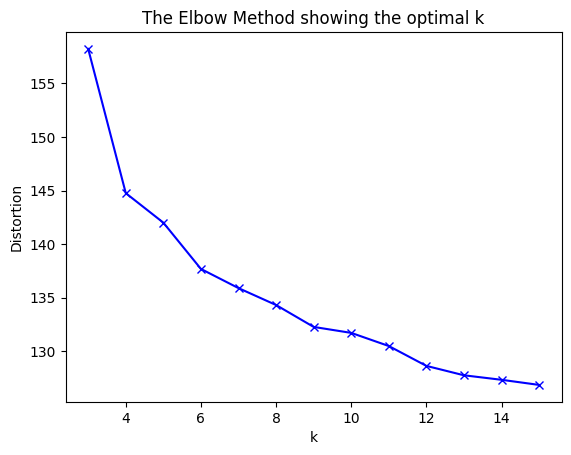

In [5]:
distortions = []
K = range(3,16)
for k in K:
    print(f"Cluster con {k} nodos")
    k_cluster = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(embedding_matrix)
    k_cluster.fit(embedding_matrix)
    distortions.append(k_cluster.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [6]:
kmeans_cluster = KMeans(n_clusters=10, init='k-means++', n_init=300, random_state=3425).fit(embedding_matrix)
kmeans_labels = kmeans_cluster.labels_

In [7]:
# run the HDBSCAN cluster
hdbs_model = hdbscan.HDBSCAN(min_cluster_size = 2)
hdbs_model.fit(embedding_matrix)
hbds_scan_labels = hdbs_model.labels_

In [8]:
# create a dataframe of the nodes with their cluster labels
nodes_labels = pd.DataFrame(zip(ids, kmeans_labels, hbds_scan_labels), columns = ['node_ids','kmeans','hdbscan'])

In [9]:
nodes_labels.hdbscan.value_counts()

hdbscan
 1    1074
-1      73
 2       4
 0       2
Name: count, dtype: int64

In [10]:
nodes_labels.kmeans.value_counts()

kmeans
9    142
8    133
5    122
6    118
1    109
4    108
2    108
0    108
7    105
3    100
Name: count, dtype: int64

In [11]:
import umap
embedding = umap.UMAP(n_components=2).fit(embedding_matrix)

/home/ignacioargel/.cache/pypoetry/virtualenvs/pow_a_pos-Du1pSIFd-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-15 19:42:05.475702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 19:42:05.475762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 19:42:05.477699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 19:42:05.664159: I tensorflow/core/platform/cp

In [15]:
nodes_labels

,node_ids,kmeans,hdbscan
0,a9ecee2e-fd09-4ac4-9e9a-ec1229887fb8,6,0
1,e6a6d5d9-a69d-4423-b809-3676eac198c3,4,1
2,c9350e64-8d4e-4742-9c25-4bae312bf6fe,9,1
3,76dc29b1-3973-4ade-9017-5a5cf238db15,8,1
4,3a0302fc-b1e9-4ed6-98c6-616483b30160,9,1
...,...,...,...
1148,52b1ee9e-f3be-4580-8e55-135821e6556b,4,1
1149,010dbecf-7615-4a05-ab07-fee18f8d8fae,1,1
1150,5c2e6888-5c6e-4984-9fbd-06668a5150d1,3,1
1151,7ded1f08-6e65-4633-9e8b-6ccb7b8c01a5,8,1


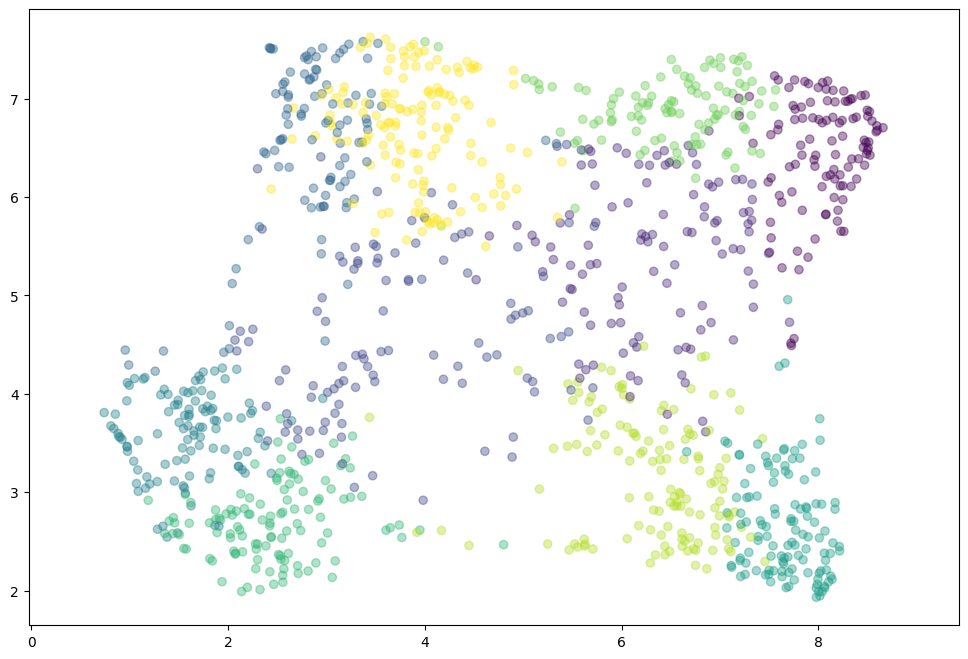

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], alpha=0.4, c=nodes_labels.kmeans, cmap='viridis')
plt.gca().set_aspect('equal', 'datalim')
plt.show()